# Module 4 - Explore the Graph

This module has the following objectives:
- Running Cypher-queries to better understand the data
- Deduplicating similar definitions
- Use GDS to find patterns in the Graph

Import our usual suspects (and some more...)

In [58]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
from neo4j import Query, GraphDatabase, RoutingControl, Result
from typing import List, Optional
from pydantic import BaseModel, Field, validator
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Setup

Load env variables

In [8]:
env_file = 'credentials.env'

In [9]:
if os.path.exists(env_file):
    load_dotenv(env_file, override=True)

    # Neo4j
    HOST = os.getenv('NEO4J_URI')
    USERNAME = os.getenv('NEO4J_USERNAME')
    PASSWORD = os.getenv('NEO4J_PASSWORD')
    DATABASE = os.getenv('NEO4J_DATABASE')

    # AI
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY']=OPENAI_API_KEY
    LLM = os.getenv('LLM')
    EMBEDDINGS_MODEL = os.getenv('EMBEDDINGS_MODEL')
else:
    print(f"File {env_file} not found.")

Connect to neo4j db

In [10]:
driver = GraphDatabase.driver(
    HOST,
    auth=(USERNAME, PASSWORD)
)

In case we want to split large files

In [11]:
def split_dataframe(df, chunk_size = 50_000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

Test the connection

In [12]:
driver.execute_query(
    """
    MATCH (n) RETURN COUNT(n) as Count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,Count
0,1494


## Explore the graph 

Now to the database and observe what is there. Example queries:

- `MATCH (n:Document) RETURN n LIMIT 25`

- `MATCH (n:Chunk) RETURN n LIMIT 25`

- `MATCH p=()-[r:PART_OF]->() RETURN p LIMIT 25`

We can also run this via the [Neo4j Python Driver](https://neo4j.com/docs/python-manual/5/) wihtin your Notebook. Let's do so below!

### How many Customers are there in the graph?

In [ ]:
 = driver.execute_query(
    """

    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

### Which products do customers have? 

### What documents are in the database?

In [13]:
document_df = driver.execute_query(
    """
    MATCH (doc:Document) 
    RETURN doc.file_name AS file_name, doc.pages AS pages
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [14]:
document_df

,file_name,pages
0,Interpolis Short-Term Travel Insurance.pdf,22
1,Rabo SpaarRekening 2020.pdf,14
2,Terms & Conditions for Online Business Service...,29
3,Payment and Online Services Terms Sept 2022.pdf,80
4,Rabo Beleggersrekening Terms 2020.pdf,25


### How many chunks are part of each document?

In [15]:
document_chunks_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)
    WITH DISTINCT doc, COLLECT(chunk) AS chunks
    RETURN doc.file_name AS file_name, doc.pages AS pages, SIZE(chunks) AS chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [16]:
document_chunks_df

,file_name,pages,chunk_count
0,Interpolis Short-Term Travel Insurance.pdf,22,46
1,Rabo SpaarRekening 2020.pdf,14,44
2,Terms & Conditions for Online Business Service...,29,88
3,Payment and Online Services Terms Sept 2022.pdf,80,354
4,Rabo Beleggersrekening Terms 2020.pdf,25,78


### Multihop questions

### What definitions did we extract from the chunks?

Let's take a look at the extracted definitions. 

Definitions can be informative about the content of chunks and can for example be used to see which chunks are **similar** by looking at overlapping definitions.

In [17]:
definitions_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, COLLECT(def) AS definitions
    RETURN doc.file_name AS file_name, SIZE(definitions) AS definition_count, [def in definitions | def.term][0] AS definition_example, [def in definitions | def.description][0] AS description_example
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [18]:
definitions_df

,file_name,definition_count,definition_example,description_example
0,Interpolis Short-Term Travel Insurance.pdf,511,Interpolis,a trade name of Achmea Schadeverzekeringen N.V...
1,Rabo SpaarRekening 2020.pdf,696,Rabo,Savings Account 2020
2,Terms & Conditions for Online Business Service...,1216,liability,significant fault of the insured
3,Payment and Online Services Terms Sept 2022.pdf,5600,Payment,Any payment transaction resulting from the pay...
4,Rabo Beleggersrekening Terms 2020.pdf,1345,Rabo,Savings Account 2020


### How many definitions do we on average extract from chunks?

In [19]:
definitions_per_chunk_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, chunk, COUNT(def) AS definition_count
    RETURN doc.file_name AS file_name, AVG(definition_count) AS avg_definitions_per_chunk_count, MIN(definition_count) AS min_definitions_per_chunk_count, MAX(definition_count) AS max_definitions_per_chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [20]:
definitions_per_chunk_df

,file_name,avg_definitions_per_chunk_count,min_definitions_per_chunk_count,max_definitions_per_chunk_count
0,Interpolis Short-Term Travel Insurance.pdf,11.108696,1,18
1,Rabo SpaarRekening 2020.pdf,15.818182,2,29
2,Terms & Conditions for Online Business Service...,13.818182,3,27
3,Payment and Online Services Terms Sept 2022.pdf,15.954416,1,45
4,Rabo Beleggersrekening Terms 2020.pdf,17.243590,2,30


### How many shared definitions do documents have? 

In [21]:
doc_name = "Payment and Online Services Terms Sept 2022.pdf"  # We can use parameters inside queries

shared_definitions_df = driver.execute_query(
    """
    MATCH (doc1:Document {file_name: $doc_name})<-[:PART_OF]-(:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(:Chunk)-[:PART_OF]->(doc2:Document)
    WHERE doc1 <> doc2
    WITH DISTINCT doc1, doc2, COLLECT(DISTINCT def) AS definitions
    RETURN doc1.file_name AS file_name_1, doc2.file_name AS file_name_2, SIZE(definitions) AS shared_definitions_count ORDER BY shared_definitions_count DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    doc_name=doc_name
)

In [22]:
shared_definitions_df

,file_name_1,file_name_2,shared_definitions_count
0,Payment and Online Services Terms Sept 2022.pdf,Rabo Beleggersrekening Terms 2020.pdf,139
1,Payment and Online Services Terms Sept 2022.pdf,Rabo SpaarRekening 2020.pdf,125
2,Payment and Online Services Terms Sept 2022.pdf,Terms & Conditions for Online Business Service...,94
3,Payment and Online Services Terms Sept 2022.pdf,Interpolis Short-Term Travel Insurance.pdf,30


### What definitions are mentioned most frequently within chunks?

Some definitions are mentioned in many chunks. These "supernodes" are often not informative as they do not capture specific information about the particular chunk itself.

In [25]:
definition_count_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [28]:
definition_count_df

,definition,description,chunk_count,document_count
0,You,"the account holder, and/or all account holders...",527,5
1,We,The Coöperative Rabobank U.A.,484,5
2,Account,The payment account you hold with us.,284,4
3,App,An application used to access an Online Servic...,277,5
4,Payment,Any payment transaction resulting from the pay...,253,5
5,for example,shall be construed as for example without limi...,231,5
6,credit,What you use the credit for,219,3
7,Credit,Includes a construction deposit and is subject...,219,3
8,Rabo,Savings Account 2020,205,4
9,Online service,Services that allow you to conduct (banking) b...,175,3


## Deduplicate definitions

As you can see, there are many similar/duplicate definitions that we would ideally merge together. That's what we'll try in this section!

In [54]:
levenshtein_definitions_df = driver.execute_query(
    """
    MATCH (a:Definition), (b:Definition)
    WHERE elementId(a) < elementId(b) AND apoc.text.distance(toLower(a.term), toLower(b.term)) < 3
    RETURN a.term, b.term
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [55]:
levenshtein_definitions_df

,a.term,b.term
0,Insurance Terms and Conditions,insurance terms and conditions
1,General terms and conditions,General Terms and Conditions
2,Event,agent
3,person,a person
4,agent,amend
...,...,...
129,Balance tiers,balance tiers
130,Current (credit) limit,current (credit) limit
131,Margin obligation,margin obligation
132,Margin obligation,Margin obligations


## Use embeddings

Load an embedding model

In [59]:
embeddings_model = OpenAIEmbeddings(
    model = EMBEDDINGS_MODEL,
    openai_api_key = OPENAI_API_KEY
)

Add an embedding for every chunk in the DataFrame

In [60]:
df = driver.execute_query(
    """
    MATCH (def:Definition)
    RETURN def.term AS term, def.description AS description
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [62]:
df['embedding'] = df['term'].apply(lambda x: embeddings_model.embed_query(x))

In [69]:
# handig om CALL hier te doen??
for _, row in df.iterrows():
    driver.execute_query(
        """
        MATCH (def:Definition {term: $term})
        SET def.embedding = $embedding
        WITH def
        CALL db.create.setNodeVectorProperty(def, "embedding", def.embedding)
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        result_transformer_= lambda r: r.to_df(),
        term=row['term'],
        embedding=row['embedding']
    )

Create the [vector index](https://neo4j.com/docs/cypher-manual/current/indexes/semantic-indexes/vector-indexes/#create-vector-index) in Neo4j

In [70]:
query = """
    CREATE VECTOR INDEX `definition-embeddings` IF NOT EXISTS
    FOR (def:Definition) ON (def.embedding)
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 1536,
            `vector.similarity_function`: 'cosine'
        } 
    }
"""

In [71]:
driver.execute_query(
    query,
    database_=DATABASE,
    routing_=RoutingControl.WRITE
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x7a8307bf8f80>, keys=[])

In [72]:
schema_result_df  = driver.execute_query(
    'SHOW INDEXES',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)
schema_result_df.head()

,id,name,state,populationPercent,type,entityType,labelsOrTypes,properties,indexProvider,owningConstraint,lastRead,readCount
0,6,chunk-embeddings,ONLINE,100.0,VECTOR,NODE,[Chunk],[embedding],vector-2.0,None,2025-05-13T14:20:35.541000000+00:00,64
1,7,definition-embeddings,ONLINE,100.0,VECTOR,NODE,[Definition],[embedding],vector-2.0,None,None,0
2,0,index_343aff4e,ONLINE,100.0,LOOKUP,NODE,None,None,token-lookup-1.0,None,2025-05-14T07:08:46.068000000+00:00,4463
3,1,index_f7700477,ONLINE,100.0,LOOKUP,RELATIONSHIP,None,None,token-lookup-1.0,None,2025-05-12T12:24:46.937000000+00:00,13
4,4,unique_chunk,ONLINE,100.0,RANGE,NODE,[Chunk],[id],range-1.0,unique_chunk,2025-05-13T14:20:27.037000000+00:00,10872


In [104]:
df = driver.execute_query(
    """
    MATCH (n:Definition)
    CALL db.index.vector.queryNodes('definition-embeddings', 10, n.embedding)
    YIELD node AS similar, score
    WHERE elementId(n) < elementId(similar)
    RETURN n.term AS source, similar.term AS target, score
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [114]:
df

,source,target,score
0,Interpolis,proxy,0.895279
1,Interpolis,Rabo,0.894104
2,Interpolis,agent,0.891205
3,Short-term Travel Insurance,Travel and accommodation costs for up to 2 oth...,0.916260
4,Short-term Travel Insurance,additional travel expenses,0.915237
...,...,...,...
3245,Entry and/or exit of a partner or a member,Termination of Agreement,0.907669
3246,Entry and/or exit of a partner or a member,End of agreement,0.900558
3247,Entry and/or exit of a partner or a member,Agreement(s),0.899628
3248,No statutory right of withdrawal,No transfer or pledge,0.909042


In [108]:
df.loc[df["score"] > 0.97].head(25)

,source,target,score
11,Insurance Terms and Conditions,insurance terms and conditions,0.983322
12,Insurance Terms and Conditions,Insurance Terms,0.975143
63,General terms and conditions,General Terms and Conditions,0.984711
123,Which events are covered? And which are not?,Which events are covered?,0.976822
175,General Terms and Conditions,Terms and Conditions,0.973114
223,The travel costs to and from the hospital for ...,Travel costs to and from the hospital for acco...,0.988098
300,Article 2.2,Article 2.3,0.972488
349,Rabo Savings Account,Rabo Savings Account for private customers,0.972748
355,General Terms and Conditions Rabo Savings Acco...,General Terms and Conditions Rabo Savings Acco...,0.972107
374,Rabo Online Banking,Rabo Banking App,0.973480


In [116]:
similar_terms = df.loc[df["score"] > 0.97]
len(similar_terms)

127

In [118]:
driver.execute_query(
    """
        MATCH p=()-[r:MENTIONS]->() RETURN COUNT(r) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,9368


In [119]:
driver.execute_query(
    """
        MATCH (n:Definition) RETURN COUNT(n) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,733


In [120]:
for _, row in similar_terms.iterrows():
    driver.execute_query(
        """
        MATCH (a:Definition {term: $source}), (b:Definition {term: $target})
        CALL apoc.refactor.mergeNodes([a, b], {
            properties: "overwrite",
            mergeRels: true
        })
        YIELD node
        RETURN node
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        result_transformer_= lambda r: r.to_df(),
        source=row['source'],
        target=row['target']
    )

In [121]:
driver.execute_query(
    """
        MATCH p=()-[r:MENTIONS]->() RETURN COUNT(r) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,7477


In [122]:
driver.execute_query(
    """
        MATCH (n:Definition) RETURN COUNT(n) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,633


Look once again at the most occurring definitions

In [123]:
definition_count_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [124]:
definition_count_df

,definition,description,chunk_count,document_count
0,You,"the account holder, and/or all account holders...",527,5
1,We,The Coöperative Rabobank U.A.,484,5
2,Account,The payment account you hold with us.,284,4
3,App,An application used to access an Online Servic...,277,5
4,Payment,Any payment transaction resulting from the pay...,253,5
5,for example,shall be construed as for example without limi...,231,5
6,Credit,Includes a construction deposit and is subject...,219,3
7,Rabo,Savings Account 2020,205,4
8,Online Service,A service that requires the arrangement of Int...,175,3
9,Agreement,the agreement concluded between you and us in ...,144,5


### Write Property

Set the degree property on `Definition` nodes

In [ ]:
# Set property
driver.execute_query(
    """
    MATCH (chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(chunk) AS chunk_count
    SET def.degree = chunk_count
    RETURN COUNT(*) AS rows_processed
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    result_transformer_= lambda r: r.to_df()
)

,rows_processed
0,392


### Chunk Similarity

We can define the similarity of chunks based on the number of definitions they have in common. 

In [ ]:
threshold = 50  # Used to filter out frequently occurring definitions

similar_chunks_df = driver.execute_query(
    """
    MATCH (chunk_1:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(chunk_2:Chunk)
    WHERE chunk_1 > chunk_2 AND def.degree <= $threshold
    WITH DISTINCT chunk_1, chunk_2, COLLECT(DISTINCT def.term) AS definitions, COUNT(DISTINCT def) AS definition_count
    WHERE definition_count > 2
    RETURN chunk_1.id AS chunk_1_id ,chunk_1.chunk AS chunk_1, chunk_2.id AS chunk_2_id, chunk_2.chunk AS chunk_2, definitions, definition_count ORDER BY definition_count DESC

    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    threshold=threshold
)

In [ ]:
len(similar_chunks_df)

1468

In [ ]:
similar_chunks_df

,chunk_1_id,chunk_1,chunk_2_id,chunk_2,definitions,definition_count
0,349,zónder u dat van tevoren te laten weten.\na U ...,332,a U overlijdt en wij verwachten dat uw erfgena...,"[bewind, curatele, wettelijke schuldsanering, ...",13
1,389,"Apple Pay, Google Pay of in de Rabo App\nq uw ...",388,Woordenlijst Voorwaarden betalen en online die...,"[middelen, rabo app, apple pay, gezichtsherken...",10
2,289,een specifieke incassomachtiging.\n150. Wat ge...,280,Hoofdstuk 6 Betalen en ontvangen53 Voorwaarden...,"[incasso, schriftelijk, idIN, idin, incassomac...",10
3,280,Hoofdstuk 6 Betalen en ontvangen53 Voorwaarden...,277,of er sprake is van een incassomachtiging. \n2...,"[incasso, schriftelijk, idIN, idin, incassomac...",9
4,289,een specifieke incassomachtiging.\n150. Wat ge...,277,of er sprake is van een incassomachtiging. \n2...,"[incasso, schriftelijk, idIN, idin, incassomac...",9
...,...,...,...,...,...,...
1463,69,Kosten\n20. Welke verschillende soorten kosten...,51,U kunt dit dan vaak doen door dit in te stelle...,"[creditcards, digitale passen, digitale pas]",3
1464,71,c limieten die gelden voor betaalpassen en cre...,69,Kosten\n20. Welke verschillende soorten kosten...,"[creditcards, tarieven- en limietenoverzicht, ...",3
1465,71,c limieten die gelden voor betaalpassen en cre...,70,betreffende de vergoedingen’ . De overheid ver...,"[creditcards, tarieven- en limietenoverzicht, ...",3
1466,235,"3. Ook bij het activeren van een digitale pas,...",51,U kunt dit dan vaak doen door dit in te stelle...,"[digitale passen, digitale pas, apparaat]",3


Load the overlapping definition count to the database as new relationship

In [ ]:
for chunk in split_dataframe(similar_chunks_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MERGE (p1:Chunk {id:row.chunk_1_id})
        MERGE (p2:Chunk {id:row.chunk_2_id})
        MERGE (p1)-[s:OVERLAPPING_DEFINITIONS]->(p2)
        SET s.overlap = row.definition_count
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

Take a minute to explore the `OVERLAPPING_DEFINITIONS` network in the database

- `MATCH p=()-[:OVERLAPPING_DEFINITIONS]->() RETURN p LIMIT 50`

- `MATCH p=()-[r:OVERLAPPING_DEFINITIONS]->() WHERE r.overlap >= 5 RETURN p LIMIT 50`

- `MATCH p=()-[r:OVERLAPPING_DEFINITIONS]->() WHERE r.overlap >= 10 RETURN p LIMIT 50`

### Communities

Let's run some Graph Data Science based on Chunks and Definitions. Let's first setup the [Graph Data Science Client](https://neo4j.com/docs/graph-data-science-client/current/).

In [ ]:
gds = GraphDataScience.from_neo4j_driver(driver=driver)
gds.set_database(DATABASE)
gds.version()

'2.12.0'

Let's investigate the Chunks that are similar in the graph (based on the definitions they share). For that we first need to create a [Graph object](https://neo4j.com/docs/graph-data-science-client/current/graph-object/)

In [ ]:
graph_name = "chunk_similarity_projection"
node_projection = ["Chunk"]
rel_projection = {"OVERLAPPING_DEFINITIONS": {"orientation": 'UNDIRECTED', "properties": "overlap"}, }

In [ ]:
G, res = gds.graph.project(graph_name, node_projection, rel_projection)

In [ ]:
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 0, 'max': 52, 'p90': 19, 'p999': 52, '...",chunk_similarity_projection,neo4j,local,2361 KiB,2417856,398,2936,{'relationshipProjection': {'OVERLAPPING_DEFIN...,0.018582,2025-05-07T18:26:21.528822741+02:00,2025-05-07T18:26:21.528822741+02:00,"{'graphProperties': {}, 'nodes': {'Chunk': {}}...","{'graphProperties': {}, 'nodes': {'Chunk': {}}..."


Run the [Leiden Algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/leiden/) for Community Detection

In [ ]:
gds.leiden.write(
    G,
    writeProperty='leiden_community',
    relationshipWeightProperty='overlap',
    maxLevels=100,
    gamma=1.5,
    theta=0.001,
    concurrency = 1,
    randomSeed = 42
)

writeMillis                                                             10
nodePropertiesWritten                                                  398
ranLevels                                                                3
didConverge                                                           True
nodeCount                                                              398
communityCount                                                         123
communityDistribution    {'min': 1, 'p5': 1, 'max': 72, 'p999': 72, 'p9...
modularity                                                        0.586683
modularities             [0.5655290575438672, 0.5801466490825345, 0.586...
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                           50
configuration            {'writeProperty': 'leiden_community', 'randomS...
Name: 0, dtype: object

In [ ]:
communities_df = driver.execute_query(
    """
    MATCH (c:Chunk)
    RETURN c.leiden_community AS community, COUNT(*) as member_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [ ]:
communities_df.sort_values(by='member_count', ascending=False)

,community,member_count
14,9,72
25,19,41
5,86,34
23,5,34
1,71,28
...,...,...
118,92,1
119,93,1
120,94,1
121,95,1


Check communities based on Chunks with high overlap

In [ ]:
community_check_df = driver.execute_query(
    """
    MATCH (c1:Chunk)-[s:OVERLAPPING_DEFINITIONS]->(c2:Chunk)
    WHERE s.overlap > 5
    RETURN s.overlap AS Overlap, c1.chunk AS chunk_1, c1.leiden_community AS community_1, c2.chunk AS chunk_2, c2.leiden_community AS community_2 ORDER BY s.overlap DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [ ]:
community_check_df.head(10)

,Overlap,chunk_1,community_1,chunk_2,community_2
0,13,zónder u dat van tevoren te laten weten.\na U ...,47,a U overlijdt en wij verwachten dat uw erfgena...,47
1,10,een specifieke incassomachtiging.\n150. Wat ge...,5,Hoofdstuk 6 Betalen en ontvangen53 Voorwaarden...,5
2,10,"Apple Pay, Google Pay of in de Rabo App\nq uw ...",9,Woordenlijst Voorwaarden betalen en online die...,9
3,9,aan deze (rechts)handelingen.\n 2 De medewerki...,86,rekeninghouder(s) doet.\n 4 Als een rekeningh...,86
4,9,Woordenlijst Voorwaarden betalen en online die...,9,volmacht heeft gegeven.\n3. Een elektronische ...,9
5,9,Woordenlijst Voorwaarden betalen en online die...,9,betaalopdrachten te geven en/of gebruik te mak...,9
6,9,Woordenlijst Voorwaarden betalen en online die...,9,Hoofdstuk 6 Betalen en ontvangen51 Voorwaarden...,9
7,9,Hoofdstuk 6 Betalen en ontvangen53 Voorwaarden...,5,of er sprake is van een incassomachtiging. \n2...,5
8,9,een specifieke incassomachtiging.\n150. Wat ge...,5,of er sprake is van een incassomachtiging. \n2...,5
9,9,gemachtigd heeft via een Digitale Incassomacht...,5,Hoofdstuk 6 Betalen en ontvangen55 Voorwaarden...,5


Check some high definition occurrences in the communities

In [ ]:
communities_definitions_df = gds.run_cypher('''
    MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
    WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
    WHERE cnt > 5
    RETURN *
    ORDER BY leiden_community, cnt DESC
''')


In [ ]:
communities_definitions_df

,cnt,definition,leiden_community
0,29,incasso,5
1,23,incassomachtiging,5
2,17,incassant,5
3,16,incassobetaling,5
4,13,idIN,5
...,...,...,...
89,7,totale te betalen bedrag,105
90,6,overeenkomst,105
91,6,betaalpakket,105
92,6,jaarlijks kostenpercentage,105


## Plot Communities with their Definition count

In [ ]:


df = gds.run_cypher("""
MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
WHERE cnt > 5
RETURN leiden_community, definition, cnt
""")

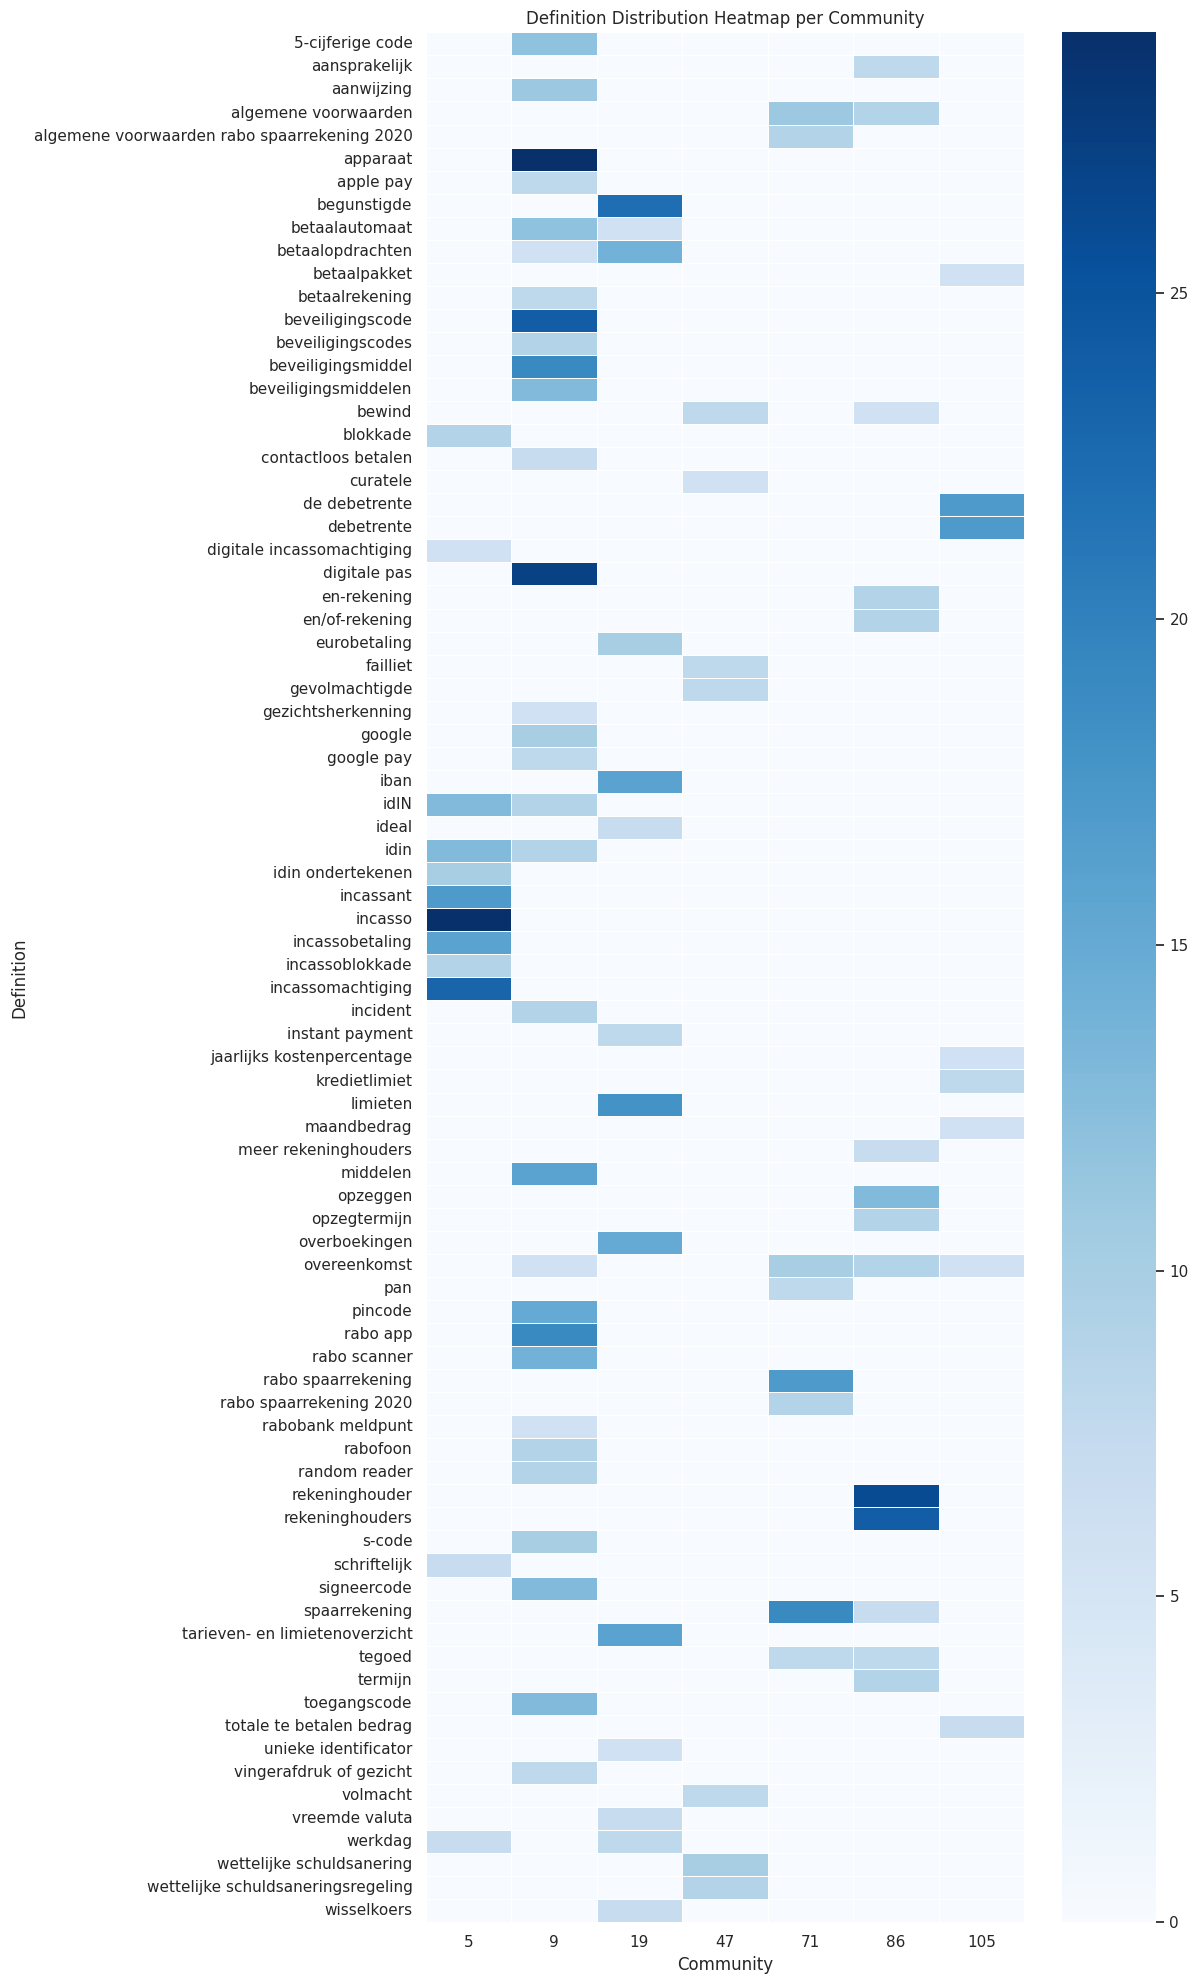

In [ ]:
pivot_table = df.pivot(index="definition", columns="leiden_community", values="cnt").fillna(0).sort_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 20))
sns.heatmap(pivot_table, cmap="Blues", yticklabels=True, linewidths=0.5)
plt.xlabel("Community")
plt.ylabel("Definition")
plt.title("Definition Distribution Heatmap per Community")
plt.tight_layout()
plt.show()